# Target Trial Emulation: Translation from R to Python

This notebook provides a Python implementation of the **Target Trial Emulation** process, originally outlined in the [RPubs article by Alan Yang](https://rpubs.com/alanyang0924/TTE). The goal is to replicate the R-based workflow using Python libraries such as `pandas`, `statsmodels`, and `scikit-learn`.

## Overview

The process involves the following **8 steps**:

1. **Load Libraries and Data**: Import necessary Python libraries and load the observational dataset.
2. **Define Estimands**: Specify the estimand of interest, such as **Intention-to-Treat (ITT)** or **Per-Protocol (PP)**.
3. **Create Directories for Saving Files**: Set up directories to save intermediate and final results.
4. **Define Functions for Weight Calculation**: Implement functions to calculate **Inverse Probability of Censoring Weights (IPCW)** for treatment switching and informative censoring.
5. **Expand the Dataset**: Transform the observational data into a sequence of trials using pre-defined expansion options.
6. **Calculate Weights for the Expanded Dataset**: Compute weights for the expanded dataset to adjust for biases.
7. **Fit Marginal Structural Models (MSM)**: Estimate causal effects using weighted regression models.
8. **Aggregate Predictions and Plot Survival Probability**: Generate predictions (e.g., survival probabilities) and visualize results to compare treatment effects over time.

## Dataset

The dataset (`data_censored.csv`) should contain the following columns:
- `id`: Unique identifier for each subject.
- `period`: Time period.
- `treatment`: Treatment indicator (0 or 1).
- `x1`, `x2`, `x3`, `x4`: Covariates.
- `age`: Age of the subject.
- `outcome`: Binary outcome (0 or 1).
- `censored`: Censoring indicator (0 or 1).
- `eligible`: Eligibility indicator (0 or 1).

## References

- Original R Tutorial: [RPubs - Target Trial Emulation](https://rpubs.com/alanyang0924/TTE)
- Python Libraries Used: `pandas`, `statsmodels`, `scikit-learn`, `matplotlib`

# Step 1: Load Libraries and Data

In [9]:
import os
from tempfile import mkdtemp
import pandas as pd
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Load the dataset
data_censored = pd.read_csv("Data/data_censored.csv")
print(data_censored.head())

   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


# Step 2: Define Estimands

In [10]:
trial_pp = {"estimand": "PP"}  # Per-protocol
trial_itt = {"estimand": "ITT"}  # Intention-to-treat

# Set data for Per-protocol and ITT
trial_pp.update({
    "data": data_censored,
    "id_col": "id",
    "period_col": "period",
    "treatment_col": "treatment",
    "outcome_col": "outcome",
    "eligible_col": "eligible"
})

trial_itt.update(trial_pp)

# Step 3: Create Directories for Saving Files

In [11]:
trial_pp_dir = os.path.join(mkdtemp(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(mkdtemp(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

print(f"Per-protocol directory: {trial_pp_dir}")
print(f"Intention-to-treat directory: {trial_itt_dir}")

Per-protocol directory: C:\Users\ANGELO~1\AppData\Local\Temp\tmpleqnirzl\trial_pp
Intention-to-treat directory: C:\Users\ANGELO~1\AppData\Local\Temp\tmp2ff6sb0u\trial_itt


# Step 4: Define Functions for Weight Calculation

In [12]:
def calculate_weights(data, numerator_formula, denominator_formula, treatment_col):
    """Calculate weights for treatment switching."""
    numerator_model = LogisticRegression()
    numerator_model.fit(data[numerator_formula.split(" + ")], data[treatment_col])

    denominator_model = LogisticRegression()
    denominator_model.fit(data[denominator_formula.split(" + ")], data[treatment_col])

    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]
    return numerator_probs / denominator_probs

def calculate_censor_weights(data, censor_event, numerator_formula, denominator_formula):
    """Calculate weights for informative censoring."""
    numerator_model = LogisticRegression()
    numerator_model.fit(data[numerator_formula.split(" + ")], 1 - data[censor_event])

    denominator_model = LogisticRegression()
    denominator_model.fit(data[denominator_formula.split(" + ")], 1 - data[censor_event])

    numerator_probs = numerator_model.predict_proba(data[numerator_formula.split(" + ")])[:, 1]
    denominator_probs = denominator_model.predict_proba(data[denominator_formula.split(" + ")])[:, 1]
    return numerator_probs / denominator_probs

# Step 5: Expand the Dataset into a Sequence of Trials

In [13]:
def expand_trials(data, id_col, period_col, treatment_col, outcome_col):
    """Expand the dataset into a sequence of trials."""
    expanded_data = []
    for period in data[period_col].unique():
        trial_data = data[data[period_col] <= period].copy()
        trial_data["trial_period"] = period
        expanded_data.append(trial_data)
    return pd.concat(expanded_data)

# Expand the dataset
trial_pp_expanded = expand_trials(
    data=trial_pp["data"],
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome"
)

# Step 6: Calculate Weights for the Expanded Dataset

In [14]:
trial_pp["switch_weights"] = calculate_weights(
    data=trial_pp_expanded,
    numerator_formula="age",
    denominator_formula="age + x1 + x3",
    treatment_col="treatment"
)

trial_pp["censor_weights"] = calculate_censor_weights(
    data=trial_pp_expanded,
    censor_event="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1"
)

trial_itt["censor_weights"] = calculate_censor_weights(
    data=trial_pp_expanded,
    censor_event="censored",
    numerator_formula="x2",
    denominator_formula="x2 + x1"
)

# Combine weights
trial_pp["weights"] = trial_pp["switch_weights"] * trial_pp["censor_weights"]
trial_itt["weights"] = trial_itt["censor_weights"]

# Step 7: Fit the Marginal Structural Model (MSM)

In [15]:
trial_pp["outcome_formula"] = "outcome ~ treatment + x2 + x3 + x4"
trial_itt["outcome_formula"] = "outcome ~ treatment + x2 + x3 + x4"

def fit_msm(data, formula, weights):
    """Fit a marginal structural model."""
    model = smf.glm(formula, data=data, family=sm.families.Binomial(), freq_weights=weights)
    return model.fit()

# Fit the MSM
msm_results = fit_msm(
    data=trial_pp_expanded,
    formula=trial_pp["outcome_formula"],
    weights=trial_pp["weights"]
)

print(msm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                outcome   No. Observations:                 9388
Model:                            GLM   Df Residuals:                  9492.23
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -649.19
Date:                Fri, 07 Mar 2025   Deviance:                       1298.4
Time:                        13:01:58   Pearson chi2:                 7.34e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.02717
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7039      0.147    -25.115      0.0

# Step 8: Aggregate Predictions and Plot Survival Probability

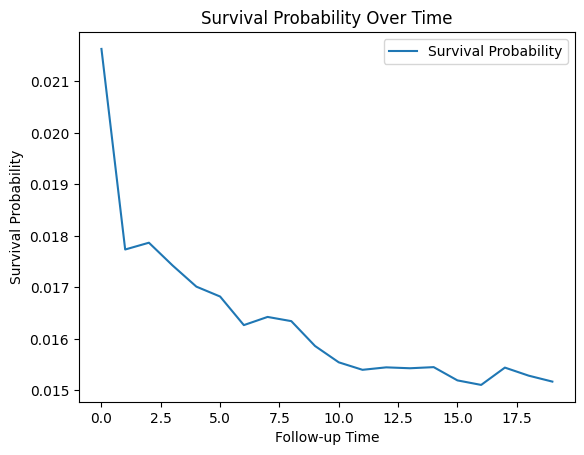

In [16]:
# Add predicted survival probabilities to the expanded dataset
trial_pp_expanded["predicted_survival"] = msm_results.predict(exog=trial_pp_expanded)

# Aggregate predictions by time
aggregated_predictions = trial_pp_expanded.groupby("trial_period")["predicted_survival"].mean()

# Plot survival probability
plt.plot(aggregated_predictions.index, aggregated_predictions.values, label="Survival Probability")
plt.xlabel("Follow-up Time")
plt.ylabel("Survival Probability")
plt.title("Survival Probability Over Time")
plt.legend()
plt.show()